### test

Device: cuda
Loading D:\학교\3-2\파이썬기반 딥러닝\3-2_jester_recognation\jester_mediapipe_csv\val_data.csv...


d:\Program\anaconda3\envs\dl\lib\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


모델 가중치 로드 성공: best_split_model.pth
추론 진행 중... (데이터 개수: 2497)


100%|██████████| 79/79 [00:08<00:00,  9.74it/s]



Test Accuracy: 82.54%

Classification Report:
                              precision    recall  f1-score   support

                  No gesture       0.48      0.92      0.63       256
          Doing other things       0.86      0.77      0.81       713
 Zooming In With Two Fingers       0.96      0.84      0.90       257
Zooming Out With Two Fingers       0.95      0.85      0.90       261
   Zooming In With Full Hand       0.95      0.85      0.90       262
  Zooming Out With Full Hand       0.96      0.87      0.91       260
                    Thumb Up       0.81      0.76      0.78       238
                  Thumb Down       0.97      0.83      0.89       250

                    accuracy                           0.83      2497
                   macro avg       0.87      0.84      0.84      2497
                weighted avg       0.87      0.83      0.84      2497

Confusion Matrix 그리는 중...


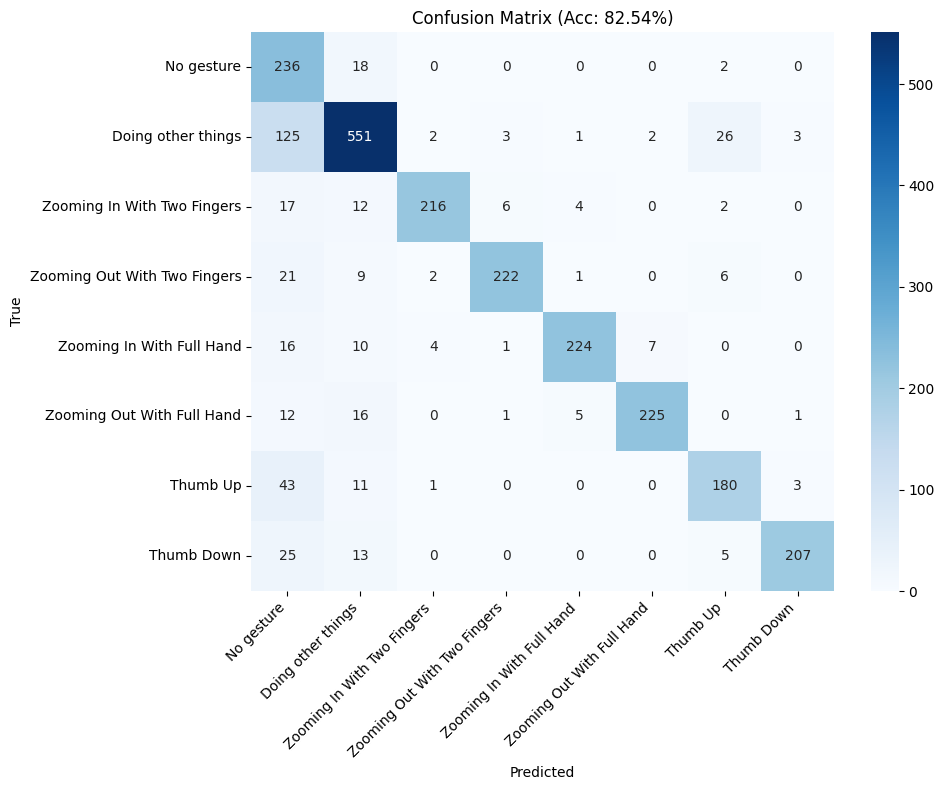

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm

# [중요] model.py에서 모델 클래스 import
from model import SE_TCN

# ==========================================
# 1. 환경 설정
# ==========================================
DATA_ROOT = r"D:\학교\3-2\파이썬기반 딥러닝\3-2_jester_recognation\jester_mediapipe_csv"
TEST_PATH = os.path.join(DATA_ROOT, "val_data.csv") # 테스트할 CSV 경로
MODEL_PATH = "best_split_model.pth"

TARGET_LABELS = [
    "No gesture", 
    "Doing other things",
    "Zooming In With Two Fingers", 
    "Zooming Out With Two Fingers",
    "Zooming In With Full Hand", 
    "Zooming Out With Full Hand",
    "Thumb Up", 
    "Thumb Down" 
]
LABEL_MAP = {label: i for i, label in enumerate(TARGET_LABELS)}
NUM_CLASSES = len(TARGET_LABELS)

INPUT_CHANNELS = 126
MAX_SEQ_LEN = 40
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 2. Dataset & Transforms (학습 코드와 동일하게 구성)
# ==========================================
class JesterRawDataset(Dataset):
    def __init__(self, csv_path):
        # 파일 존재 여부 확인
        if not os.path.exists(csv_path):
            raise FileNotFoundError(f"데이터 파일을 찾을 수 없습니다: {csv_path}")
            
        print(f"Loading {csv_path}...")
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['label_name'].isin(TARGET_LABELS)]
        
        self.grouped = self.df.groupby('video_id')
        self.video_ids = list(self.grouped.groups.keys())
        
        self.feat_cols = []
        for i in range(21):
            self.feat_cols.extend([f'joint_{i}_x', f'joint_{i}_y', f'joint_{i}_z'])
            
        self.labels = []
        for vid in self.video_ids:
            label_str = self.grouped.get_group(vid).iloc[0]['label_name']
            self.labels.append(LABEL_MAP[label_str])

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        vid_id = self.video_ids[idx]
        group = self.grouped.get_group(vid_id)
        label_name = group.iloc[0]['label_name']
        label = LABEL_MAP[label_name]
        
        # Raw Data 반환
        features = group[self.feat_cols].replace(0, np.nan).interpolate().fillna(0).values.astype(np.float32)
        return features, label

# --- 전처리 클래스들 (학습 코드에서 복사) ---
class NormalizeSkeleton:
    def __call__(self, x):
        T = x.shape[0]
        skeleton = x.reshape(T, 21, 3)
        wrist = skeleton[:, 0:1, :]
        skeleton = skeleton - wrist
        dist = np.linalg.norm(skeleton[:, 9, :] - skeleton[:, 0, :], axis=1, keepdims=True) + 1e-6
        skeleton = skeleton / dist[:, :, np.newaxis]
        return skeleton.reshape(T, -1)

class ComputeVelocity:
    def __call__(self, x):
        velocity = np.zeros_like(x)
        velocity[1:] = x[1:] - x[:-1]
        combined = np.concatenate([x, velocity], axis=1)
        return combined

class ToTensorAndPad:
    def __init__(self, max_len=40):
        self.max_len = max_len
    def __call__(self, x):
        seq_len = x.shape[0]
        input_dim = x.shape[1]
        if seq_len < self.max_len:
            pad_len = self.max_len - seq_len
            padding = np.zeros((pad_len, input_dim), dtype=np.float32)
            x = np.vstack([x, padding])
        else:
            x = x[:self.max_len, :]
        x = x.transpose(1, 0)
        return torch.tensor(x, dtype=torch.float32)

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, x):
        for t in self.transforms:
            x = t(x)
        return x

class HoloTouchCollate:
    """ 테스트용 Collate Function (증강 없이 전처리만 수행) """
    def __init__(self):
        # 테스트이므로 RandomHorizontalFlip 제외
        transforms_list = [
            NormalizeSkeleton(),
            ComputeVelocity(),
            ToTensorAndPad(MAX_SEQ_LEN)
        ]
        self.transform = Compose(transforms_list)

    def __call__(self, batch):
        inputs, targets = [], []
        for feature, label in batch:
            processed_feature = self.transform(feature)
            inputs.append(processed_feature)
            targets.append(label)
        return torch.stack(inputs), torch.tensor(targets, dtype=torch.long)

# ==========================================
# 3. 평가 함수
# ==========================================
def evaluate():
    print(f"Device: {DEVICE}")
    
    # 1. 데이터 로드
    # [핵심 수정] collate_fn을 반드시 넣어줘야 전처리가 수행됨
    test_ds = JesterRawDataset(TEST_PATH)
    test_collate = HoloTouchCollate() # is_train=False (기본값)
    
    test_loader = DataLoader(
        test_ds, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        collate_fn=test_collate  # <--- 필수!
    )
    
    # 2. 모델 로드
    model = SE_TCN(
        num_inputs=INPUT_CHANNELS, 
        num_channels=[64, 64, 128, 128], 
        num_classes=NUM_CLASSES
    ).to(DEVICE)

    if os.path.exists(MODEL_PATH):
        try:
            model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
            print(f"모델 가중치 로드 성공: {MODEL_PATH}")
        except Exception as e:
            print(f"모델 로드 실패: {e}")
            return

    model.eval()
    
    all_preds = []
    all_targets = []
    
    print(f"추론 진행 중... (데이터 개수: {len(test_ds)})")
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.numpy())
            
    # 3. 결과 분석
    acc = accuracy_score(all_targets, all_preds)
    print(f"\nTest Accuracy: {acc*100:.2f}%")
    
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, target_names=TARGET_LABELS))
    
    # 4. Confusion Matrix 시각화
    print("Confusion Matrix 그리는 중...")
    cm = confusion_matrix(all_targets, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=TARGET_LABELS, yticklabels=TARGET_LABELS)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (Acc: {acc*100:.2f}%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    evaluate()

1. Precision: Positive라고 예측한 것 중에서, 진짜 Positive는 얼마나 될까?
2. Recall: 실제 Positive 중에서, 내가 얼마나 많이 찾아냈을까

### onnx를 통한 inference 및 평가 분석

Loading Model: HoloTouch_SE_TCN.onnx...
model Loaded!

70초 동안 자유롭게 동작을 취해주세요!
(줌 인/아웃, 따봉, 그랩 등 다양한 동작 테스트)

테스트 종료!

자유 동작 테스트 결과 (2095 프레임)
🔹 평균 응답 속도: 0.75 ms
🔹 최대 응답 속도: 2.78 ms
🔹 99% 하위 속도(P99): 1.61 ms (렉 발생 기준)

[ 인식된 의미있는 동작 수 (Frames) ]
Label
Thumb Up                        192
Zooming Out With Two Fingers    191
Zooming Out With Full Hand      155
Thumb Down                       97
Zooming In With Two Fingers      62
Zooming In With Full Hand        33


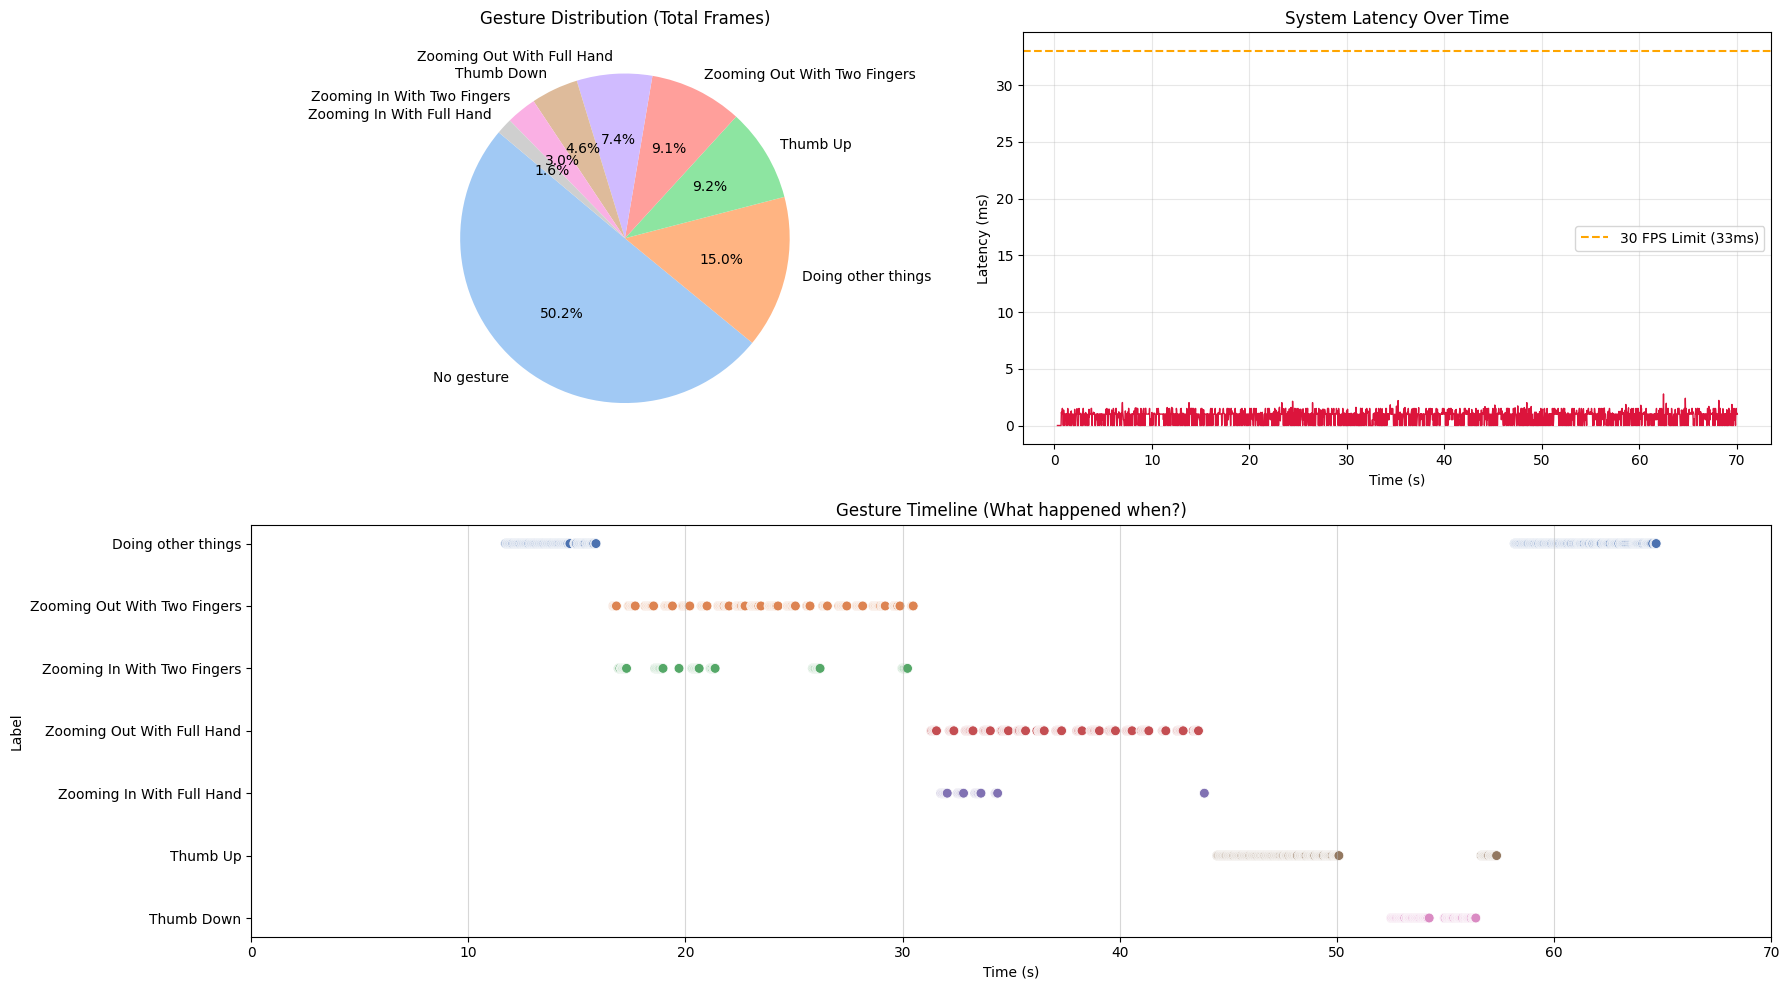

In [10]:
import cv2
import mediapipe as mp
import numpy as np
import onnxruntime as ort
import time
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ================= ⚙️ 설정 (Configuration) =================
MODEL_PATH = "HoloTouch_SE_TCN.onnx" # 모델 경로 확인 필요

INPUT_CHANNELS = 126
MAX_SEQ_LEN = 40
NUM_CLASSES = 8
TEST_DURATION = 70  # 테스트 시간 (초)

TARGET_LABELS = [
    "No gesture", "Doing other things",
    "Zooming In With Two Fingers", "Zooming Out With Two Fingers",
    "Zooming In With Full Hand", "Zooming Out With Full Hand",
    "Thumb Up", "Thumb Down" 
]

CONFIDENCE_THRESHOLD = 0.8

# ================= 🧮 전처리 함수 =================
def normalize_skeleton(data):
    T = data.shape[0]
    skeleton = data.reshape(T, 21, 3)
    wrist = skeleton[:, 0:1, :]
    skeleton = skeleton - wrist
    dist = np.linalg.norm(skeleton[:, 9, :] - skeleton[:, 0, :], axis=1, keepdims=True) + 1e-6
    skeleton = skeleton / dist[:, :, np.newaxis]
    return skeleton.reshape(T, -1)

def preprocess_buffer(buffer):
    features = np.array(buffer, dtype=np.float32)
    features = normalize_skeleton(features)
    velocity = np.zeros_like(features)
    if features.shape[0] > 1:
        velocity[1:] = features[1:] - features[:-1]
    combined = np.concatenate([features, velocity], axis=1)
    
    seq_len = combined.shape[0]
    if seq_len < MAX_SEQ_LEN:
        pad_len = MAX_SEQ_LEN - seq_len
        padding = np.zeros((pad_len, INPUT_CHANNELS), dtype=np.float32)
        combined = np.vstack([combined, padding])
    else:
        combined = combined[-MAX_SEQ_LEN:, :]
    combined = combined.transpose(1, 0)
    input_data = np.expand_dims(combined, axis=0).astype(np.float32)
    return input_data

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

# ================= 📈 성능 모니터링 클래스 =================
class PerformanceMonitor:
    def __init__(self):
        self.logs = [] # {timestamp, label, conf, latency}
        self.start_time = None

    def start(self):
        self.start_time = time.time()

    def log(self, label, conf, latency):
        if self.start_time is None: return
        elapsed = time.time() - self.start_time
        self.logs.append({
            "Time (s)": elapsed,
            "Label": label,
            "Confidence": conf,
            "Latency (ms)": latency * 1000
        })

    def report(self):
        if not self.logs:
            print("데이터가 수집되지 않았습니다.")
            return

        df = pd.DataFrame(self.logs)
        
        print("\n" + "="*50)
        print(f"자유 동작 테스트 결과 ({len(df)} 프레임)")
        print("="*50)

        # 1. 요약 통계
        avg_latency = df["Latency (ms)"].mean()
        max_latency = df["Latency (ms)"].max()
        p99_latency = df["Latency (ms)"].quantile(0.99)
        
        print(f"🔹 평균 응답 속도: {avg_latency:.2f} ms")
        print(f"🔹 최대 응답 속도: {max_latency:.2f} ms")
        print(f"🔹 99% 하위 속도(P99): {p99_latency:.2f} ms (렉 발생 기준)")

        # 2. 동작별 인식 횟수 (프레임 수)
        # 'No gesture'와 'Doing other things'를 제외하고 의미있는 동작만 필터링 가능
        gesture_counts = df[~df['Label'].isin(["No gesture", "Doing other things"])]['Label'].value_counts()
        print("\n[ 인식된 의미있는 동작 수 (Frames) ]")
        print(gesture_counts.to_string())

        # 3. 그래프 시각화
        self.plot_dashboard(df)

    def plot_dashboard(self, df):
        plt.figure(figsize=(18, 10))
        
        # [그래프 1] 동작 인식 비율 (Pie Chart)
        plt.subplot(2, 2, 1)
        label_counts = df['Label'].value_counts()
        plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
        plt.title("Gesture Distribution (Total Frames)")

        # [그래프 2] 시간대별 응답 속도 (Line Chart) -> 렉 확인용
        plt.subplot(2, 2, 2)
        sns.lineplot(data=df, x="Time (s)", y="Latency (ms)", color="crimson", linewidth=1)
        plt.axhline(y=33, color='orange', linestyle='--', label='30 FPS Limit (33ms)')
        plt.title("System Latency Over Time")
        plt.legend()
        plt.grid(True, alpha=0.3)

        # [그래프 3] 동작 타임라인 (Scatter/Strip Plot) -> 언제 무엇을 했나
        plt.subplot(2, 1, 2)
        # 의미있는 동작만 강조하기 위해 No gesture는 투명하게 처리하거나 제외
        valid_df = df[df['Confidence'] > CONFIDENCE_THRESHOLD]
        sns.scatterplot(data=valid_df, x="Time (s)", y="Label", hue="Label", s=50, palette="deep", legend=False)
        plt.title("Gesture Timeline (What happened when?)")
        plt.grid(True, axis='x', alpha=0.5)
        plt.xlim(0, TEST_DURATION)

        plt.tight_layout()
        plt.show()

# ================= 🚀 메인 실행 =================
def run_benchmark():
    print(f"Loading Model: {MODEL_PATH}...")
    try:
        session = ort.InferenceSession(MODEL_PATH, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
        input_name = session.get_inputs()[0].name
        print("model Loaded!")
    except Exception as e:
        print(f"Error: {e}")
        return

    mp_hands = mp.solutions.hands
    cap = cv2.VideoCapture(0)
    cap.set(3, 1280)
    cap.set(4, 720)

    history_buffer = deque(maxlen=MAX_SEQ_LEN)
    monitor = PerformanceMonitor()
    
    with mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.7) as hands:
        
        print(f"\n{TEST_DURATION}초 동안 자유롭게 동작을 취해주세요!")
        print("(줌 인/아웃, 따봉, 그랩 등 다양한 동작 테스트)")
        time.sleep(2) # 준비 시간
        
        monitor.start()
        start_time = time.time()
        
        while cap.isOpened():
            now = time.time()
            elapsed = now - start_time
            if elapsed > TEST_DURATION:
                print("\n테스트 종료!")
                break
            
            ret, image = cap.read()
            if not ret: break
            
            image = cv2.flip(image, 1)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # 1. 랜드마크 추출
            results = hands.process(image_rgb)
            
            landmarks_flat = None
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    coords = []
                    for lm in hand_landmarks.landmark:
                        coords.extend([lm.x, lm.y, lm.z])
                    landmarks_flat = np.array(coords, dtype=np.float32)
                    break
            
            if landmarks_flat is None:
                landmarks_flat = np.zeros(63, dtype=np.float32)
            
            history_buffer.append(landmarks_flat)
            
            # 2. 추론 및 시간 측정
            label = "No gesture"
            conf = 0.0
            latency = 0.0
            
            if len(history_buffer) >= 15:
                t0 = time.time() # 시작
                
                input_data = preprocess_buffer(history_buffer)
                outputs = session.run(None, {input_name: input_data})[0]
                
                t1 = time.time() # 종료
                latency = t1 - t0
                
                probs = softmax(outputs)
                idx = np.argmax(probs)
                conf = probs[0][idx]
                
                if conf > CONFIDENCE_THRESHOLD:
                    label = TARGET_LABELS[idx]
            
            # 3. 데이터 기록
            monitor.log(label, conf, latency)
            
            # 4. 화면 표시
            # 타이머
            remaining = int(TEST_DURATION - elapsed)
            color = (0, 255, 0) if remaining > 10 else (0, 0, 255)
            
            cv2.rectangle(image, (0,0), (1280, 60), (30, 30, 30), -1)
            cv2.putText(image, f"Time Left: {remaining}s", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            cv2.putText(image, f"Action: {label} ({conf*100:.0f}%)", (400, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.putText(image, f"Lat: {latency*1000:.1f}ms", (1000, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
            
            cv2.imshow('Benchmark Mode', image)
            if cv2.waitKey(1) & 0xFF == 27: break

    cap.release()
    cv2.destroyAllWindows()
    
    # 5. 결과 리포트 생성
    monitor.report()

if __name__ == "__main__":
    run_benchmark()

inference test

In [9]:
import cv2
import mediapipe as mp
import numpy as np
import onnxruntime as ort  # PyTorch instead of ONNXRuntime
import time
from collections import deque

# ================= ⚙️ Configuration =================
# ONNX Model Path
MODEL_PATH = "HoloTouch_SE_TCN.onnx"

# Parameters (Must match training config)
INPUT_CHANNELS = 126  # (21 joints * 3 coords) + (21 joints * 3 velocity)
MAX_SEQ_LEN = 40
NUM_CLASSES = 8

TARGET_LABELS = [
    "No gesture",
    "Doing other things",
    "Zooming In With Two Fingers",
    "Zooming Out With Two Fingers",
    "Zooming In With Full Hand",
    "Zooming Out With Full Hand",
    "Thumb Up",    
    "Thumb Down" 
]

# UI Settings
CONFIDENCE_THRESHOLD = 0.8
ACTION_COOLDOWN = 0.3

# ================= 🧮 Preprocessing Functions (Identical logic) =================
def normalize_skeleton(data):
    """
    Normalize skeleton data based on the wrist position.
    Input: (T, 63) -> Output: (T, 63)
    """
    T = data.shape[0]
    skeleton = data.reshape(T, 21, 3)
    
    # 1. Move wrist (index 0) to origin (0,0,0)
    wrist = skeleton[:, 0:1, :]
    skeleton = skeleton - wrist
    
    # 2. Scale by hand size (distance from wrist to middle finger MCP)
    # Middle Finger MCP is index 9
    dist = np.linalg.norm(skeleton[:, 9, :] - skeleton[:, 0, :], axis=1, keepdims=True) + 1e-6
    skeleton = skeleton / dist[:, :, np.newaxis]
    
    return skeleton.reshape(T, -1)

def preprocess_buffer(buffer):
    """
    Convert deque buffer to ONNX input format (Numpy).
    """
    # 1. List -> Numpy (T, 63)
    features = np.array(buffer, dtype=np.float32)
    
    # 2. Normalize
    features = normalize_skeleton(features)
    
    # 3. Calculate Velocity
    velocity = np.zeros_like(features)
    if features.shape[0] > 1:
        velocity[1:] = features[1:] - features[:-1]
        
    # 4. Concatenate (Channel: 63 + 63 = 126)
    combined = np.concatenate([features, velocity], axis=1) # (T, 126)
    
    # 5. Padding
    seq_len = combined.shape[0]
    if seq_len < MAX_SEQ_LEN:
        pad_len = MAX_SEQ_LEN - seq_len
        padding = np.zeros((pad_len, INPUT_CHANNELS), dtype=np.float32)
        combined = np.vstack([combined, padding])
    else:
        combined = combined[-MAX_SEQ_LEN:, :]
        
    # 6. Transpose (Length, Channel) -> (Channel, Length)
    # ONNX model expects (Batch, Channel, Length)
    combined = combined.transpose(1, 0)
    
    # 7. Add Batch Dimension (1, C, L)
    # Note: ONNX Runtime expects Numpy arrays, not Torchtensors
    input_data = np.expand_dims(combined, axis=0).astype(np.float32)
    
    return input_data

def softmax(x):
    """ Compute softmax values for each sets of scores in x. """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

# ================= 🎨 UI Class =================
class TargetUI:
    def __init__(self, w, h):
        self.x = w // 2
        self.y = h // 2
        self.size = 150
        self.color = (0, 255, 0) 
        self.thickness = 2
        self.text = "Ready"

    def update(self, label):
        if "Zooming In" in label:
            self.size = min(400, self.size + 5)
            self.text = "Zoom In (+)"
            self.color = (0, 255, 255) 
        elif "Zooming Out" in label:
            self.size = max(50, self.size - 5)
            self.text = "Zoom Out (-)"
            self.color = (255, 0, 255) 
        elif "Thumb Up" in label:
            self.color = (0, 255, 0) 
            self.text = "Confirmed (OK)"
            self.thickness = 5
        elif "Thumb Down" in label:
            self.color = (0, 0, 255) 
            self.text = "Rejected (No)"
            self.thickness = 2
        else:
            self.text = "Waiting..."
            self.thickness = 2
            
    def draw(self, image):
        top_left = (int(self.x - self.size/2), int(self.y - self.size/2))
        bottom_right = (int(self.x + self.size/2), int(self.y + self.size/2))
        cv2.rectangle(image, top_left, bottom_right, self.color, self.thickness)
        cv2.putText(image, self.text, (top_left[0], top_left[1] - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, self.color, 2)

# ================= 🎥 Main Execution =================
def run_inference_onnx():
    # 1. Load ONNX Model
    print(f"Loading ONNX model from {MODEL_PATH}...")
    try:
        # Create Inference Session
        # providers=['CUDAExecutionProvider', 'CPUExecutionProvider'] enables GPU if available
        session = ort.InferenceSession(MODEL_PATH, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
        input_name = session.get_inputs()[0].name
        print("✅ ONNX Model loaded successfully!")
    except Exception as e:
        print(f"❌ Failed to load ONNX model: {e}")
        return

    # 2. Initialize MediaPipe
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

    # 3. Initialize Buffer & UI
    history_buffer = deque(maxlen=MAX_SEQ_LEN)
    ui = TargetUI(1280, 720)
    
    curr_label = "No gesture"
    curr_conf = 0.0
    
    with mp_hands.Hands(
        max_num_hands=1,
        min_detection_confidence=0.7,
        min_tracking_confidence=0.7
    ) as hands:
        
        while cap.isOpened():
            success, image = cap.read()
            if not success: break
            
            # Flip & Convert color
            image = cv2.flip(image, 1)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = hands.process(image_rgb)
            
            landmarks_flat = None
            
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                    
                    # Extract (x, y, z) -> 63-dim vector
                    coords = []
                    for lm in hand_landmarks.landmark:
                        coords.extend([lm.x, lm.y, lm.z])
                    landmarks_flat = np.array(coords, dtype=np.float32)
                    break 
            
            # Zero padding if no hand detected
            if landmarks_flat is None:
                landmarks_flat = np.zeros(63, dtype=np.float32)
            
            history_buffer.append(landmarks_flat)
            
            # --- Inference ---
            if len(history_buffer) >= 15:
                # Preprocess (returns Numpy array)
                input_data = preprocess_buffer(history_buffer)
                
                # Run ONNX Inference
                # session.run returns a list of outputs, we take the first one
                outputs = session.run(None, {input_name: input_data})[0]
                
                # Softmax & Argmax (using Numpy)
                probs = softmax(outputs)
                idx = np.argmax(probs)
                curr_conf = probs[0][idx]
                curr_label = TARGET_LABELS[idx]
                
                # Update UI
                if curr_conf > CONFIDENCE_THRESHOLD:
                    if curr_label not in ["No gesture", "Doing other things"]:
                        ui.update(curr_label)
                    else:
                        ui.text = "Waiting..."
                        ui.color = (200, 200, 200)

            # --- Draw UI ---
            ui.draw(image)
            
            info_text = f"Action: {curr_label} ({curr_conf*100:.1f}%)"
            cv2.putText(image, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.8, (0, 255, 0), 2)
            
            # Buffer status bar
            ratio = len(history_buffer) / MAX_SEQ_LEN
            cv2.rectangle(image, (10, 40), (10 + int(200*ratio), 50), (255, 255, 0), -1)

            cv2.imshow('HoloTouch ONNX Inference', image)
            
            if cv2.waitKey(1) & 0xFF == 27: # ESC
                break
                
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    run_inference_onnx()

Loading ONNX model from HoloTouch_SE_TCN.onnx...
✅ ONNX Model loaded successfully!


d:\Program\anaconda3\envs\dl\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
d:\Program\anaconda3\envs\dl\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
